In [1]:
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html

def get_random_node_uniform(rng, a_huge_key_list):
    L = len(a_huge_key_list)
    i = rng.integers(0, L)
    return a_huge_key_list[i]

def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None


def update_opinions(u, v, opinions, convergence, symmetric_updating=True):
    diff = opinions[u] - opinions[v]

    opinions[u] -= convergence * diff
    
    if symmetric_updating:
        opinions[v] += convergence * diff
        
    return opinions

def effective_neighbors(u, adjG, opinions, threshold):
    
    distances = opinions - opinions[u] # vector of opinion distances
    distances[(distances < -threshold) | (distances > threshold)] = -1 # turn nodes at dist>d into -1
    distances[distances != -1] = 0 # the rest into 0
    distances += 1 # close nodes are now 1 and far away ones are 0
    
    return adjG[u]*distances # filters out non-neighbors with close opinion distance


def update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating):
    
    neighbors = effective_neighbors(u, adjG, opinions, threshold)

    effective_net[u]   = neighbors
    effective_net[:,u] = neighbors
        
    if not symmetric_updating:
        return effective_net

    neighbors = effective_neighbors(v, adjG, opinions, threshold)
    
    effective_net[v]   = neighbors
    effective_net[:,v] = neighbors
            
    return effective_net

def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float, convergence: float, initial_opinions=None,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42)):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize opinions
    if initial_opinions is None:
        opinions = rng.random(G.order())
    else:
        opinions = np.copy(initial_opinions)
    # save adjacency matrix
    adjG = nx.to_numpy_array(G)

    # get initial effective network
    effective_net = np.copy(adjG)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[u]   = neighbors
        effective_net[:,u] = neighbors

    if not fast_mode:
        # initialize the list of nets that will be returned
        network_history = [effective_net]
        opinion_history = [opinions]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = np.copy(network_history[t-1])
            opinions      = np.copy(opinion_history[t-1])

        # choose random node to update
        u = rng.choice(G.order())
        
        # get another node if u is isolated
        while not effective_net[u].sum():
            u = rng.choice(G.order())
        
        # get a random neighbor of u
        v = get_random_node_uniform(rng, np.argwhere(effective_net[u]==1))[0]

        # update their opinions
        opinions = update_opinions(u, v, opinions, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, adjG, opinions, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            network_history.append(effective_net)
            opinion_history.append(opinions)
    
    if fast_mode:
        return effective_net, opinions
    else:
        return network_history, opinion_history

def effective_network(G,threshold,opinions):
    adjG = nx.to_numpy_array(G)
    effective_net = np.copy(adjG)
    for u in G.nodes():
        # get 0-1 vector of neighbors at opinion distance <threshold
        neighbors = effective_neighbors(u, adjG, opinions, threshold)
        effective_net[u]   = neighbors
        effective_net[:,u] = neighbors
    return effective_net

def compute_iterations(symmetric_updating,iterations,net_order):
    if symmetric_updating==True:
        time = iterations/(net_order/2)
    else:
        time = iterations/net_order
    return time

def degree_distribution(G):
    adjG = nx.to_numpy_array(G)
    degrees = np.zeros(net_order)
    meandegree = 0

    for i in range(0,len(adjG[0])):
        degrees[i] = np.sum(adjG[:,i])

    degmax = int(np.max(degrees))
    degmin = int(np.min(degrees))
    dim = degmax-degmin+1
    degree_distrib = np.zeros((dim,2))

    for j in range(0,dim):
        degree_distrib[j,1] =  j+degmin

    for i in range(0,net_order):
        for j in range(0,dim):
            if(degrees[i]==(j+degmin)):
                degree_distrib[j,0] =  degree_distrib[j,0]+1
    for i in range(0,degmax-degmin+1):
        meandegree = meandegree + degree_distrib[i,0]*degree_distrib[i,1]
    meandegree = meandegree/net_order
    return degree_distrib,meandegree,dim
  

In [2]:
# METRIC/PLOT FUNCTIONS
from scipy.sparse.csgraph import connected_components

# equation 3 in the paper
def dispersion_index(G):
    sizes = np.unique(connected_components(G,directed = False)[1], return_counts=True)[1]
    return sum([size**2 for size in sizes])/(G.shape[0]**2)


# computes the avg value of a metric over a range of d values in a given net type and fixed convergence
def metric_d_data(metric, net_type, net_order, symmetric_updating, iterations,\
                       sample_size, num_points, init_d, final_d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(num_points)
    # initialize vector with x-axis points
    d = [init_d + i*(final_d-init_d)/num_points for i in range(num_points)]
    
    for i in range(num_points):
        print(".", end='') # loading
        
        # at every point we will average the metric over sample_size networks
        for j in range(sample_size):
            
            # generate network sample
            initial_net = get_net(net_type, net_order, rng)

            final_net, _ = simulate_deffuant_model(initial_net, iterations, d[i], convergence,
                                                 symmetric_updating=symmetric_updating, fast_mode=True, rng=rng)
            
            # add metric to data vect so that we can compute the avg
            metric_avgs[i] += metric(final_net)
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return d, metric_avgs


# computes the avg evolution of a metric in the deffuant model with fixed parameters in a given net type and fixed convergence
def metric_evol_data(metric, net_type, net_order, symmetric_updating,\
                          iterations, sample_size, d, convergence, rng):
    
    # initialize vector with data
    metric_avgs = np.zeros(iterations)
    
    for i in range(sample_size):
        print(".", end='') # loading
        
        # generate network sample
        initial_net = get_net(net_type, net_order, rng)

        nets, = simulate_deffuant_model(initial_net, iterations, d, convergence,\
                                       symmetric_updating=symmetric_updating, fast_mode=False, rng=rng)

        # add metric of every net so that we can compute the avg
        metric_avgs = metric_avgs + np.array([metric(net) for net in nets])
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return list(range(iterations)), metric_avgs
   

# runs simulation and sets x and y with the initial and final opinions of agents
def opinion_change_data(G, iterations, d, convergence, symmetric_updating, rng):
    
    initial_opinions = rng.random(G.order())
    final_network, final_opinions = simulate_deffuant_model(G, iterations, d, convergence,
                                                            symmetric_updating=symmetric_updating,
                                                            initial_opinions=initial_opinions, fast_mode=True, rng=rng)

    y_bar = np.array([G.degree[node] for node in G.nodes()])
    
    # rescale the bars
    y_bar = y_bar/(4*max(y_bar))
    
    return initial_opinions, final_opinions, y_bar

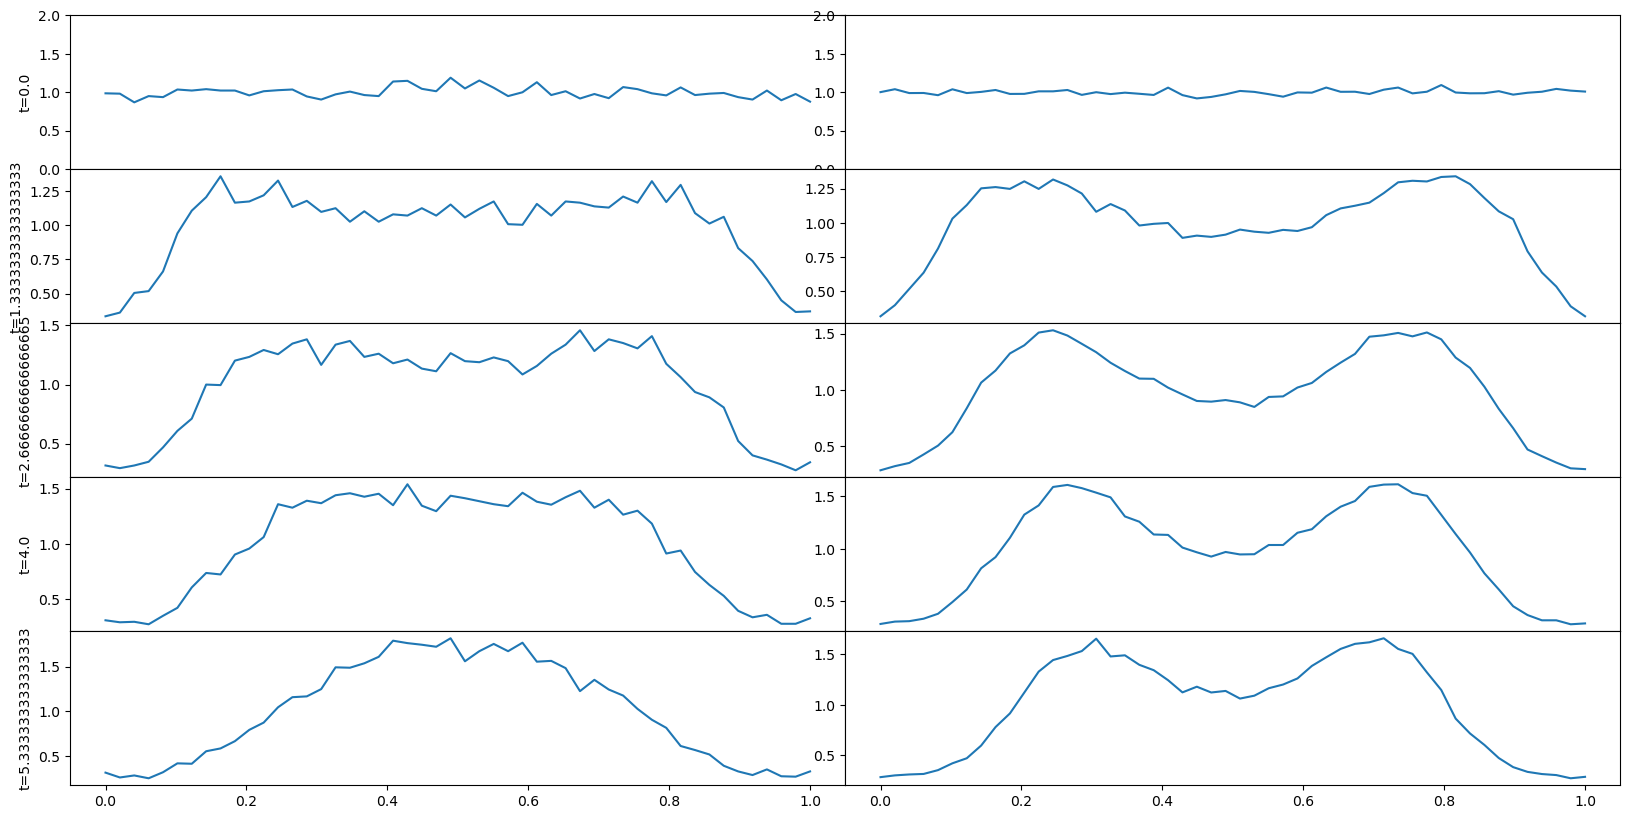

In [26]:
#Values
net_order = 300
symmetric_updating = False
iterations = 400
average = 200
times = 5
bins = 50
threshold = 0.30
convergence = 0.4

#Initialize
G = get_net('complete_mixing',net_order=net_order,rng=None)
opinionshist = np.zeros((average,bins,times))
opinionshist1 = np.zeros((average,bins,times))
opinionfinal1 = np.zeros((bins,times))
opinionshist2 = np.zeros((average,bins,times))
opinionfinal2 = np.zeros((bins,times))
time = compute_iterations(symmetric_updating,iterations,net_order)
rng = np.random.default_rng(42)
maximos = np.zeros(average)
xaxis = np.linspace(start=0,stop=1,num=bins)
numd1 = numd2 = 0

#Initialize graph
fig,ax = plt.subplots(times,2,figsize=(20,10))

#Loop for the average over the net_order nodes keeping the opinions at certain times
for i in range(0,average):
    opinions = rng.random(G.order())
    opinionshist[i,:,0] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
    for j in range(1,times):
        _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence,
                                                initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                fast_mode=True,rng=np.random.default_rng(42))
        opinionshist[i,:,j] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]

    ind = 0
    for k in range(0,bins):
        if(opinionshist[i,k,times-1]>=ind):
            maximos[i] = k
            ind = opinionshist[i,k,times-1]
    indice = int(maximos[i])
    if(0.4<xaxis[indice]<0.6):
        opinionshist1[numd1,:,:] = np.copy(opinionshist[i,:,:])
        numd1 = numd1+1
    else:
        opinionshist2[numd2,:,:] = np.copy(opinionshist[i,:,:])
        numd2 = numd2+1

opinionshist1 = opinionshist1[:(numd1),:,:]
opinionshist2 = opinionshist2[:(numd2),:,:]

ax[0,0].set_ylim(0,2)
ax[0,1].set_ylim(0,2) 

for j in range(0,times):
    opinionfinal1 = np.mean(opinionshist1,axis=0)
    opinionfinal2 = np.mean(opinionshist2,axis=0)
    ax[j,0].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal1[:,j])
    ax[j,1].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal2[:,j])
    ax[j,0].set_ylabel("t={}".format(j*time))

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

C:\Users\familia\AnacondaNuevo\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\familia\AnacondaNuevo\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


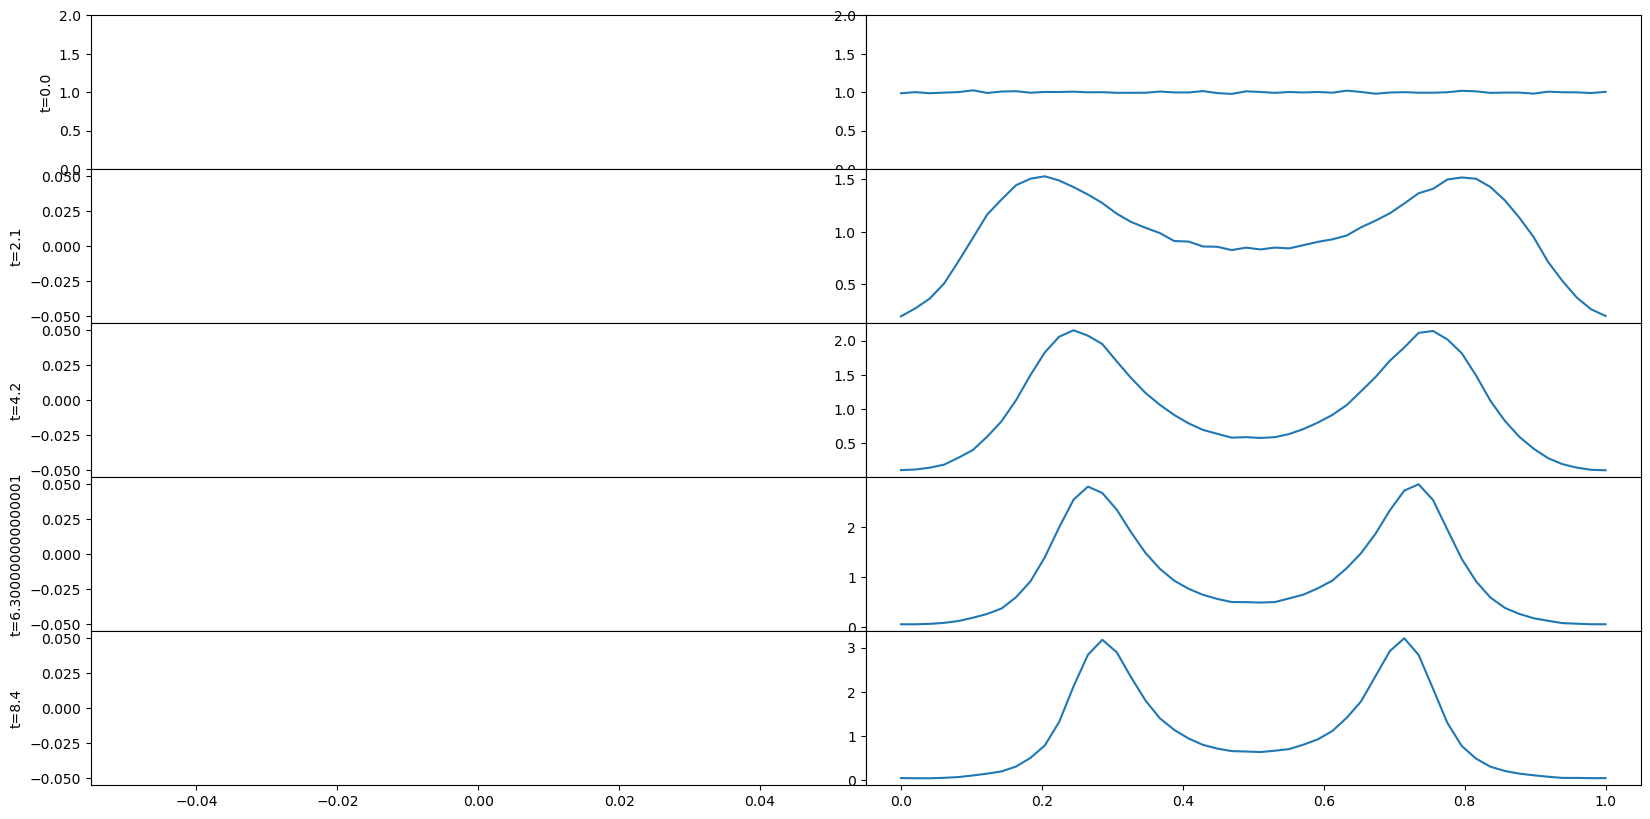

In [2]:
#Values
net_order = np.array([300,500,800,1000,1500,2000,3000])
symmetric_updating = True
iterations = np.array([400,600,900,1100,1600,2100,3100])
average = 200
times = 5
bins = 50
threshold = 0.30
convergence = 0.4

for l in range(5,6):
    #Initialize
    G = get_net('complete_mixing',net_order=net_order[l],rng=None)
    opinionshist = np.zeros((average,bins,times))
    opinionshist1 = np.zeros((average,bins,times))
    opinionfinal1 = np.zeros((bins,times))
    opinionshist2 = np.zeros((average,bins,times))
    opinionfinal2 = np.zeros((bins,times))
    time = compute_iterations(symmetric_updating,iterations[l],net_order[l])
    rng = np.random.default_rng(42)
    maximos = np.zeros(average)
    xaxis = np.linspace(start=0,stop=1,num=bins)
    numd1 = numd2 = 0

    #Initialize graph
    fig,ax = plt.subplots(times,2,figsize=(20,10))

    #Loop for the average over the net_order nodes keeping the opinions at certain times
    for i in range(0,average):
        opinions = rng.random(G.order())
        opinionshist[i,:,0] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
        for j in range(1,times):
            _,opinions = simulate_deffuant_model(G,iterations=iterations[l],threshold=threshold,convergence=convergence,
                                                    initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                    fast_mode=True,rng=np.random.default_rng(42))
            opinionshist[i,:,j] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]

        ind = 0
        for k in range(0,bins):
            if(opinionshist[i,k,times-1]>=ind):
                maximos[i] = k
                ind = opinionshist[i,k,times-1]
        indice = int(maximos[i])
        if(0.4<xaxis[indice]<0.6):
            opinionshist1[numd1,:,:] = np.copy(opinionshist[i,:,:])
            numd1 = numd1+1
        else:
            opinionshist2[numd2,:,:] = np.copy(opinionshist[i,:,:])
            numd2 = numd2+1

    opinionshist1 = opinionshist1[:(numd1),:,:]
    opinionshist2 = opinionshist2[:(numd2),:,:]

    ax[0,0].set_ylim(0,2)
    ax[0,1].set_ylim(0,2) 

    for j in range(0,times):
        opinionfinal1 = np.mean(opinionshist1,axis=0)
        opinionfinal2 = np.mean(opinionshist2,axis=0)
        ax[j,0].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal1[:,j])
        ax[j,1].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal2[:,j])
        ax[j,0].set_ylabel("t={}".format(j*time))

    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    plt.savefig("SymUpNet={}".format(net_order[l]))

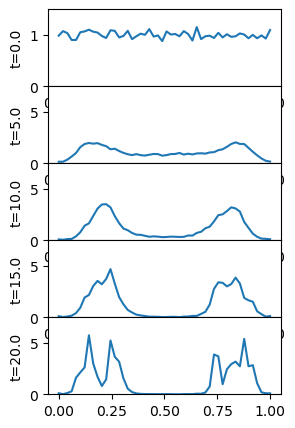

In [9]:
fig,ax = plt.subplots(times,1,figsize=(3,5))
for j in range(0,times):
    ax[j].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal[:,j])
    ax[j].set_ylabel("t={}".format(j*time))
    ax[j].set_ylim(0,7.5)
    ax[0].set_ylim(0,1.5)

plt.subplots_adjust(hspace=0)

In [33]:
#Values
net_order = 100
symmetric_updating = False
iterations = 4500
average = 10
times = 3
bins = 50
threshold = 0.2
convergence = 0.3

#Initialize
G = get_net('scale_free',net_order=net_order,rng=None)
rng = np.random.default_rng(42)
degree_distrib = []
meandegree = 0
dim = 0

degree_distrib, meandegree, dim = degree_distribution(G)



In [23]:
#Values
net_order = 300
symmetric_updating = False
iterations = 1500
average = 100
times = 5
bins = 20
threshold = 0.5
convergence = 0.5

#Initialize
G = get_net('complete_mixing',net_order=net_order,rng=None)
opinionshist = np.zeros((average,bins,times))
opinionfinal = np.zeros((bins,times))
time = compute_iterations(symmetric_updating,iterations,net_order)
rng = np.random.default_rng(42)
maximos = np.zeros(average)

#Loop for the average over the net_order nodes keeping the opinions at certain times
for i in range(0,average):
    opinions = rng.random(G.order())
    opinionshist[i,:,0] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
    for j in range(1,times):
        _,opinions = simulate_deffuant_model(G,iterations=iterations,threshold=threshold,convergence=convergence,
                                                initial_opinions=opinions,symmetric_updating=symmetric_updating,
                                                fast_mode=True,rng=np.random.default_rng(42))
        opinionshist[i,:,j] = np.histogram(opinions,bins=bins,range=(0,1),density=True)[0]
    

In [24]:
for i in range(0,average):
    ind = 0
    for k in range(0,bins):
        if(opinionshist[i,k,times-1]>=ind):
            maximos[i] = k
            ind = opinionshist[i,k,times-1]
print(maximos)

[ 9. 10. 10. 10.  9. 10.  9. 10. 10.  9.  9. 10.  9.  9.  9.  9.  9. 10.
  9. 10.  9. 10.  9. 10.  9. 10. 10. 10. 10. 10.  9. 10.  9.  9. 10. 10.
 10.  9.  9.  9.  9. 10.  8. 10.  9. 10. 10. 11. 10. 10. 10.  9. 10.  9.
 10. 10. 10. 10.  9. 10.  9.  9. 10. 10. 10.  9. 10. 10. 10. 11.  9. 10.
 10.  9. 10.  9.  9. 10.  9.  9.  9. 10. 10.  9.  9. 10. 10. 10. 10.  9.
 10. 10. 10.  9. 10.  9.  9. 10. 10. 10.]


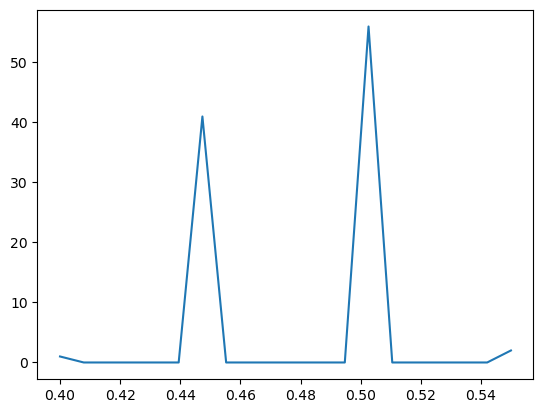

In [25]:
histmax = np.histogram(maximos,bins=20)[0]
xaxis = np.linspace(start=np.min(maximos),stop=np.max(maximos),num=bins)
plt.plot(xaxis/20,histmax)

In [21]:
opinionshist[30,:,times-1]

array([ 0.62725826,  3.13629132, 48.71705856,  7.73618527,  1.46360262,
        0.20908609,  0.41817218,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.20908609,  0.        ,  0.        ,  0.20908609])

In [7]:
media = np.mean(maximos)
desvest = np.std(maximos)
print('Media:{}, Desvest:{}'.format(media/20,desvest/20))

Media:0.479, Desvest:0.14459944674859582


Text(0, 0.5, 'Opinion')

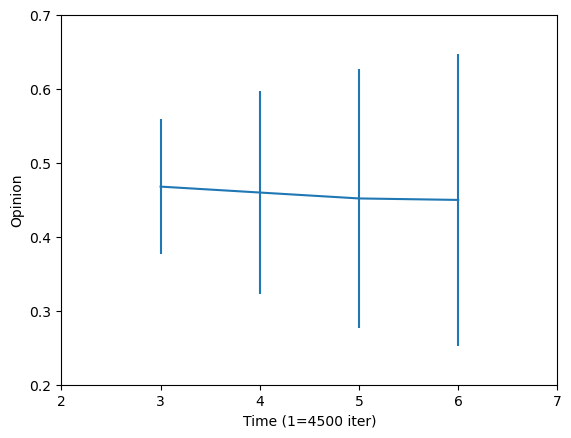

In [8]:
t = np.linspace(start=3,stop=6,num=4)
media = np.array([0.468,0.46,0.452,0.45])
desvest = np.array([0.0915,0.1374,0.1746,0.1979])
plt.errorbar(t,media,yerr=desvest)
plt.xlim(2,7)
plt.ylim(0.2,0.7)
plt.xlabel('Time (1=4500 iter)')
plt.ylabel('Opinion')

In [7]:
for j in range(0,times):
    opinionfinal1 = np.mean(opinionshist1,axis=0)
    opinionfinal2 = np.mean(opinionshist2,axis=0)
    ax[j,0].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal1[:,j])
    ax[j,1].plot(np.linspace(start=0,stop=1,num=bins),opinionfinal2[:,j])
    ax[j,0].set_ylabel("t={}".format(j*time))
    #ax[j].set_ylim(0,30)

plt.subplots_adjust(hspace=0)
plt.show()

<Figure size 640x480 with 0 Axes>

In [4]:
print(np.shape(opinionshist1),np.shape(opinionshist2))

(0, 50, 5) (200, 50, 5)
